# Goal

The goal of this project is to make a machine learning model to predict price of flights that ran in India for the year 2019 using data for 10,000+ flights.

Independent Features : 
 1. Airline
 2. Date_of_Journey  
 3. Source           
 4. Destination      
 5. Route            
 6. Dep_Time         
 7. Arrival_Time     
 8. Duration         
 9. Total_Stops      
 10. Additional_Info
 
Dependent Feature:
1. Flight Price

## 1. Data Exploration

### 1.1. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set()

In [2]:
pd.set_option('display.max_columns',None)

### 1.2. Reading the data

In [3]:
train_data = pd.read_excel("Data_Train.xlsx")

### 1.3. Taking a glimpse at top 5 rows of dataset

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### 1.4. Checking shape of data

In [5]:
train_data.shape

(10683, 11)

In [6]:
print(f'There are a total of {train_data["Airline"].nunique()} Airlines providing flights : {",".join(list(train_data["Airline"].unique()))}')

There are a total of 12 Airlines providing flights : IndiGo,Air India,Jet Airways,SpiceJet,Multiple carriers,GoAir,Vistara,Air Asia,Vistara Premium economy,Jet Airways Business,Multiple carriers Premium economy,Trujet


### 1.5. Checking data type of all columns

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


- Numerical columns like Date_of_Journey, Dep_Time, Arrival_Time, Duration, Total_Stops will need to be transformed as they are currently of object(str) datatype which predictive model will not understand.
- Categorical columns will also have to be transformed using appropriate methods 


### 1.6. Checking statistics of dataset

In [8]:
train_data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


### 1.7. Checking date range for flights

In [9]:
print(f'The Date_of_Journey ranges from {train_data["Date_of_Journey"].min()} to {train_data["Date_of_Journey"].max()}')

The Date_of_Journey ranges from 01/03/2019 to 9/06/2019


In [10]:
train_data["Duration"].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

## 2. Data Cleaning

### 2.1. Checking for NaN values

In [11]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

- There's one NA entry each in Route column as well as Total_Stops column that need to be dropped

#### 2.2. Treating NaN Values

In [12]:
train_data.dropna(inplace=True)

### 2.3. Checking for Null Values

In [13]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

- No null values are found in this dataset

In [14]:
train_data.shape

(10682, 11)

### 2.4. Checking Source & Destination of Flights

In [15]:
train_data["Source"].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [16]:
train_data["Destination"].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

- Since New Delhi & Delhi are the same city and represent the same airport, we can use the same name 'Delhi' for them

### 2.5. Treating Destination Column

In [17]:
train_data["Destination"] = train_data["Destination"].apply(lambda x:'Delhi' if x=='New Delhi' else x)

In [18]:
train_data["Destination"].unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

## 3. Feature Engineering

### 3.1. Feature Engineering for Numerical columns

- We need to extract day and date from Date_of_Journey because the predictive model we are going to build will not understand the current string format of this column
- Price of flights is generally going to be high on weekends as most people are not working then and are free to travel. Hence it makes sense to have an indicator column (1/0) mentioning if the flight date falls on a weekend or not
- We are also going to extract hours and minutes from Dep_Time, Arrival_Time as they are also needed in numeric instead of string format

In [19]:
# Checking if below code gets us the right date format
pd.to_datetime(train_data["Date_of_Journey"],format="%d/%m/%Y")

0       2019-03-24
1       2019-05-01
2       2019-06-09
3       2019-05-12
4       2019-03-01
           ...    
10678   2019-04-09
10679   2019-04-27
10680   2019-04-27
10681   2019-03-01
10682   2019-05-09
Name: Date_of_Journey, Length: 10682, dtype: datetime64[ns]

#### Adding Journey_Date, Journey_On_Weekend & Journey_Month columns

In [20]:
#  Lets extract date, weekend/not & and month of Date of journey in separate columns using .dt.day & .dt.month methods

# Extracting date
train_data["Journey_Day"] = pd.to_datetime(train_data["Date_of_Journey"],format='%d/%m/%Y').dt.day

# Extracting weekday
train_data["Journey_Weekday"] = pd.to_datetime(train_data["Date_of_Journey"],format='%d/%m/%Y').dt.weekday

# Using lambda function to check if the Journey_Date is on a weekend or not
train_data["Journey_On_Weekend"] = train_data["Journey_Weekday"].apply(lambda x:1 if x in (5,6) else 0)

# Extracting month
train_data["Journey_Month"] = pd.to_datetime(train_data["Date_of_Journey"],format='%d/%m/%Y').dt.month

In [21]:
train_data.head(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Weekday,Journey_On_Weekend,Journey_Month
0,IndiGo,24/03/2019,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,6,1,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,2,0,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,1,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,6,1,5
4,IndiGo,01/03/2019,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,4,0,3
5,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873,24,0,0,6
6,Jet Airways,12/03/2019,Banglore,Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087,12,1,0,3
7,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,08:00,05:05 02 Mar,21h 5m,1 stop,No info,22270,1,4,0,3
8,Jet Airways,12/03/2019,Banglore,Delhi,BLR → BOM → DEL,08:55,10:25 13 Mar,25h 30m,1 stop,In-flight meal not included,11087,12,1,0,3
9,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,11:25,19:15,7h 50m,1 stop,No info,8625,27,0,0,5


#### Dropping Date_of_Journey & Journey_Weekday columns

In [22]:
# Since we have converted Date_Of_Journey into 2 separate columns, we can now drop it to avoid repetition of features.
# We can also drop column Journey_Weekday as it was only used to get the Journey_On_Weekend column and its not required anymore.
train_data.drop(["Date_of_Journey","Journey_Weekday"],axis = 1, inplace = True)

#### Adding Dep_hour & Dep_min columns, dropping Dep_Time

In [23]:
# Departure time is when flight leaves the Source airport gate
# Similar to Date_of_Journey wwe can extract hour and minute from Dep_time and then drop it

#Extracting departure hour
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

#Extracting departure min
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

#Dropping Dep_time column
train_data.drop(["Dep_Time"],axis = 1, inplace = True)

In [24]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min
0,IndiGo,Banglore,Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,1,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,0,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,1,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,1,5,18,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,0,3,16,50


#### Adding Arr_hour & Arr_min columns, dropping Arrival_Time

In [25]:
# Arrival time is when flight arrives at the Destination airport gate
# Similar to Date_of_Journey wwe can extract hour and minute from Dep_time and then drop it

#Extracting departure hour
train_data["Arr_hour"] = pd.to_datetime(train_data["Arrival_Time"]).dt.hour

#Extracting departure min
train_data["Arr_min"] = pd.to_datetime(train_data["Arrival_Time"]).dt.minute

#Dropping Dep_time column
train_data.drop(["Arrival_Time"],axis = 1, inplace = True)

In [26]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,1,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,0,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,1,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,1,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,0,3,16,50,21,35


In [27]:
# # Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time
# Lets see if all the durations have hours & minutes or if there are any exceptions
print(f'Number of rows containing hours in flight duration : {train_data["Duration"].str.contains("h").sum()}')
print(f'Number of rows containing minutes in flight duration : {train_data["Duration"].str.contains("m").sum()}')

Number of rows containing hours in flight duration : 10681
Number of rows containing minutes in flight duration : 9651


In [28]:
# Checking the only flight that has duration in minutes
train_data[train_data["Duration"].str.contains("h")==False]

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min
6474,Air India,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,5m,2 stops,No info,17327,6,0,3,16,50,16,55


- This seems like an anomaly as its almost impossible for a flight to lift-off and then touch down in just 5 minutes.

#### Extracting hours and minutes from Duration column

In [29]:
# Seems like some rows have only hours in flight Duration & some rows have only minutes
# Let find a way to extract duration_hours and duration_minutes from duration column

# Assigning duration to a list so its easier to manipulate in this case
# Using below code to first bring all duration entries in same format and then extract hours & minutes
duration = list(train_data["Duration"])
for i in range(len(duration)):         
    if len(duration[i].split()) != 2: # Checks if string contains only hour or both hour & minutes
        if 'h' in duration[i]:
            duration[i] = duration[i].strip() + ' 0m' # Adds 0 minutes at the end with leading white space
        else:
            duration[i] = '0h ' + duration[i]  # Adds 0 hour at the beginning with trailing white space 

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep='h')[0]))   # Extract only hours from duration
    duration_mins.append(int(duration[i].split(sep='m')[0].split()[-1]))   # Extract only minutes from duration

#### Mapping duration hours and minutes to new columns in Dataframe

In [30]:
train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [31]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,0,3,16,50,21,35,4,45


#### Dropping the Duration column

In [32]:
# We can now drop the Duration column as its no longer needed
train_data.drop(["Duration"],axis=1,inplace=True)

In [33]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,0,3,16,50,21,35,4,45


### 2.2 Feature Engineering for categorical columns

There are several ways of handling categorical data depending on their type.

1. <span style="color: blue;">**Nominal data**</span> --> data does not have any natural order --> <span style="color: green;">**OneHotEncoder**</span> is used in this case
2. <span style="color: blue;">**Ordinal data**</span> --> data has a natural order --> <span style="color: green;">**LabelEncoder**</span> is used in this case

In [34]:
# Let check how the price of flight varies by Airline

In [35]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

<Figure size 1800x1000 with 0 Axes>

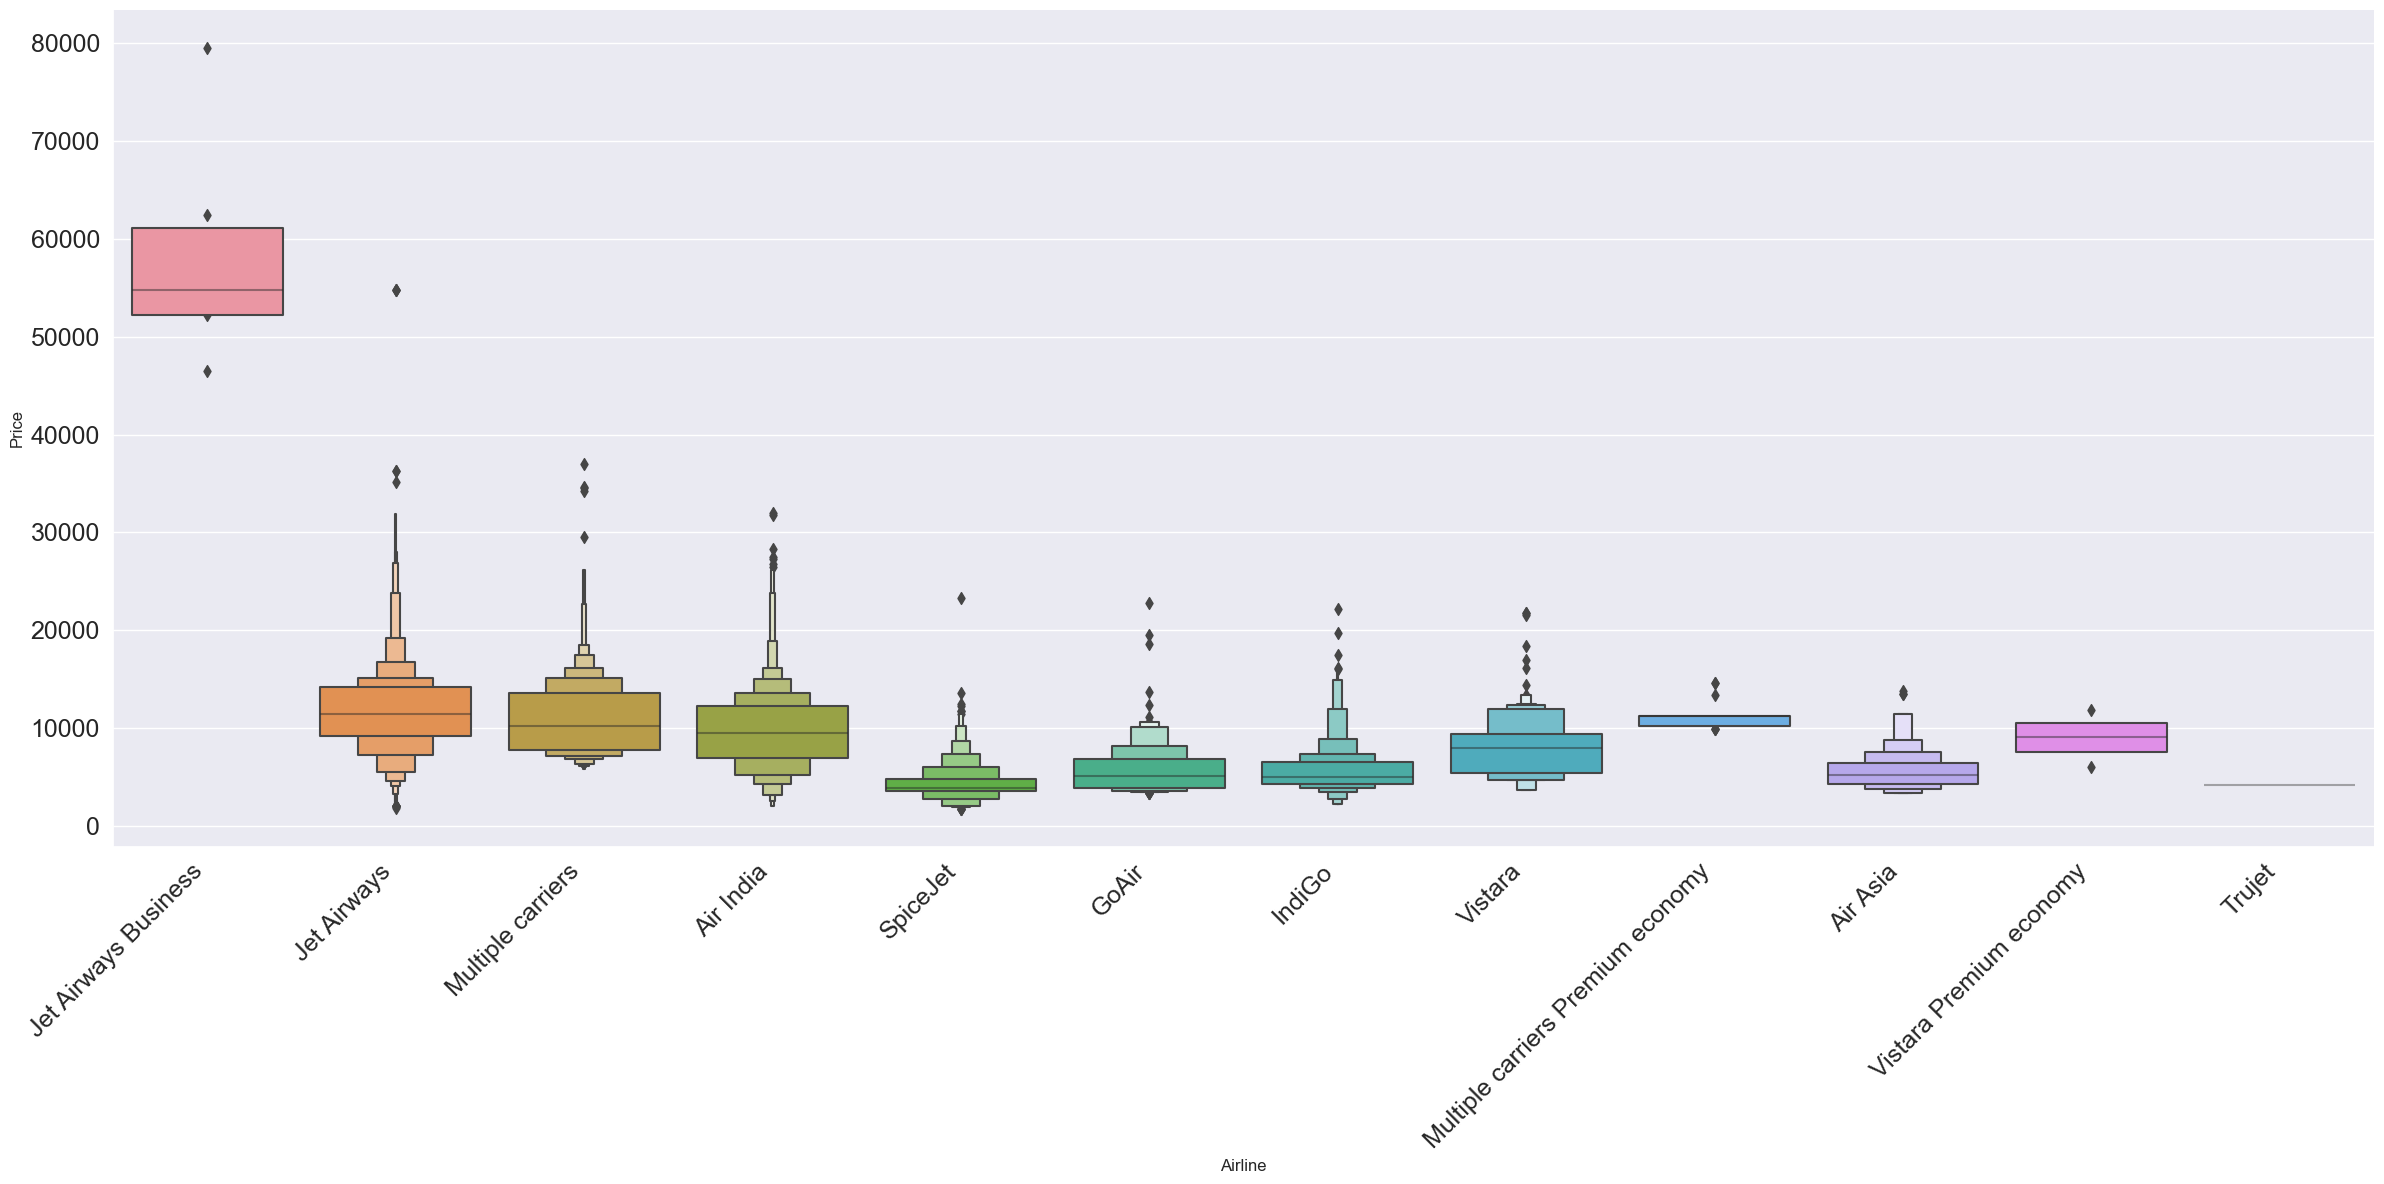

In [36]:
# Airline vs Price
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,10))
sns.catplot(data=train_data.sort_values(by="Price",ascending=False),x="Airline",y="Price",kind='boxen',height=12,aspect=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

- It seems from above figure that apart from the Jet Airways Business, all other airlines have median price around the 1000 rupees range. Hence Airline is a nominal categorical variable

#### Peforming one hot encoding for Airline feature as it is a nominal categorical variable

In [37]:
Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline,drop_first=True) # drop_first=True will drop that one extra dummy column that we don't need

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [38]:
# Lets check how the price of flight varies by Source

In [39]:
train_data["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

<Figure size 1800x1000 with 0 Axes>

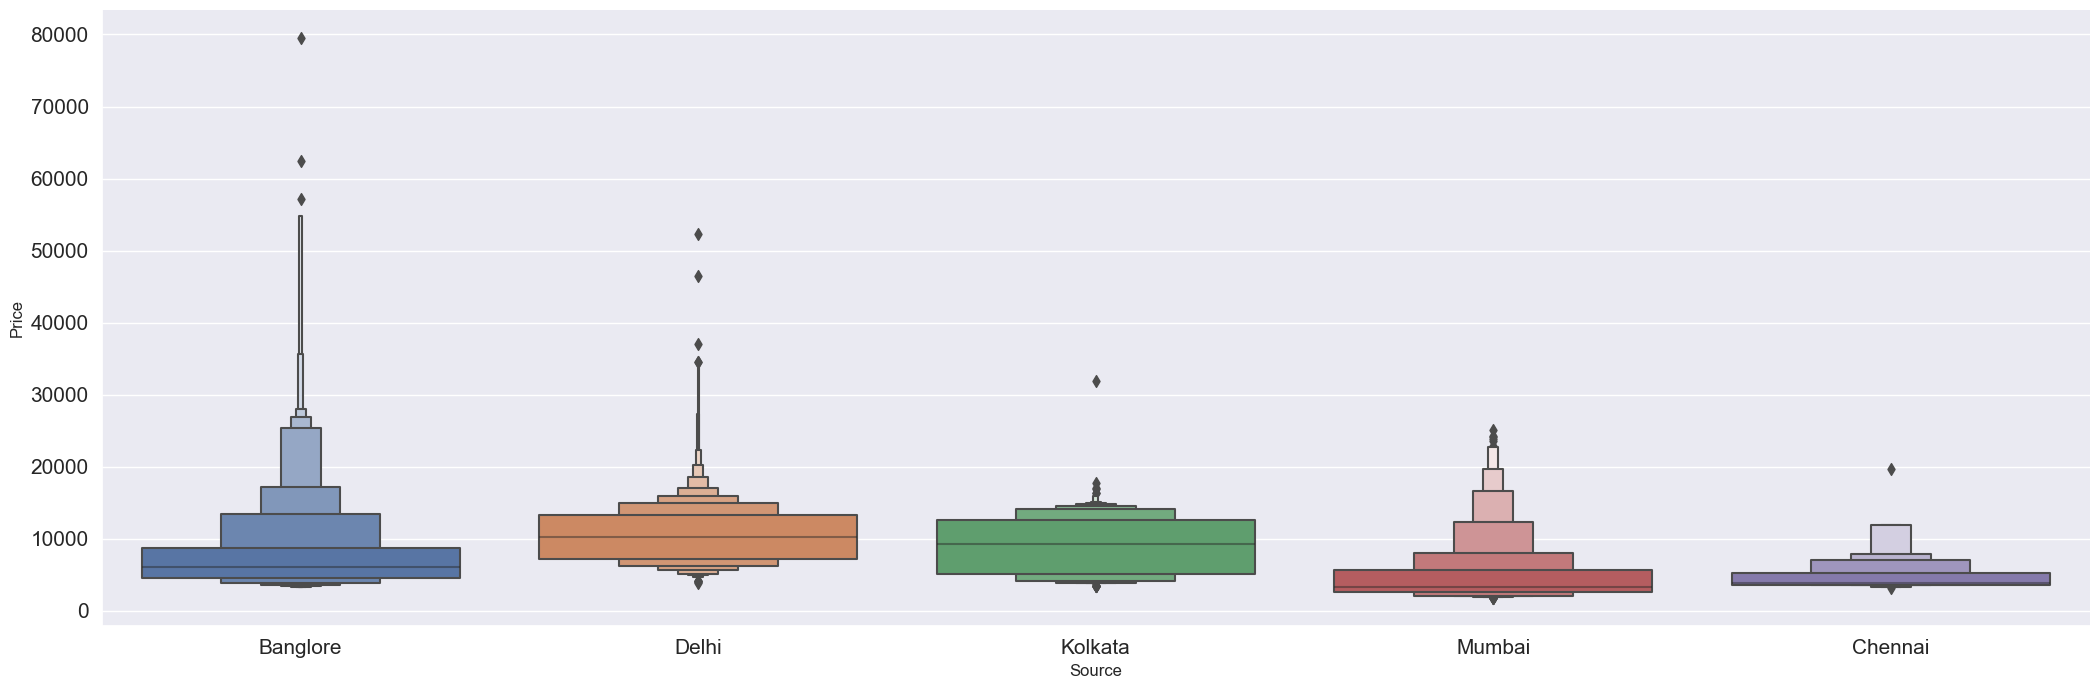

In [40]:
# Airline vs Price
plt.figure(figsize=(18,10))
sns.catplot(data=train_data.sort_values(by="Price",ascending=False),x="Source",y="Price",kind='boxen',height=7, aspect=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- It seems from above figure that apart from a few outlier flights departing from Bangalore & Delhi, most flights have the same median price. Hence, Source is a nominal categorical variable

#### Peforming one hot encoding for Source feature as it is a nominal categorical variable

In [41]:
Source = train_data[["Source"]]

Source = pd.get_dummies(Source,drop_first=True) # drop_first=True will drop that one extra dummy column that we don't need

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [42]:
# Lets check how the price of flight varies by Destination

In [43]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<Figure size 1800x1000 with 0 Axes>

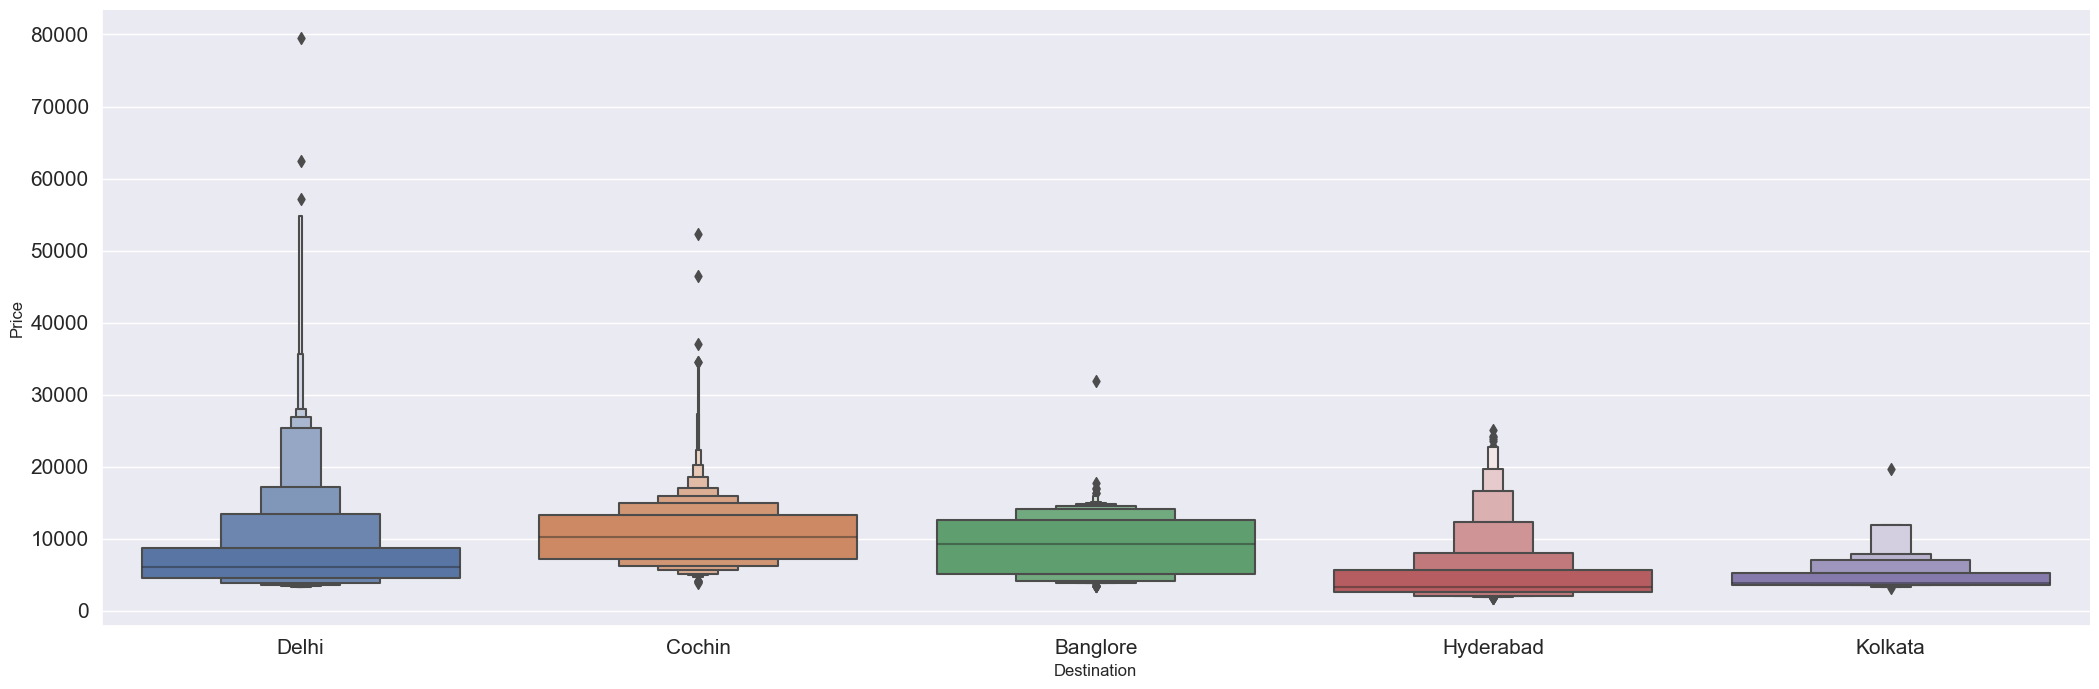

In [44]:
# Airline vs Price
plt.figure(figsize=(18,10))
sns.catplot(data=train_data.sort_values(by="Price",ascending=False),x="Destination",y="Price",kind='boxen',height=7, aspect=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- It seems from above figure that apart from a few outlier flights landing in Delhi & Cochin, most flights have the same median price. Hence, Destination is a nominal categorical variable

#### Peforming one hot encoding for Destination feature as it is a nominal categorical variable

In [45]:
Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination,drop_first=True) # drop_first=True will drop that one extra dummy column that we don't need

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [46]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,0,3,16,50,21,35,4,45


In [47]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

- Route columns has the same info as No of stops columns so we don't need it

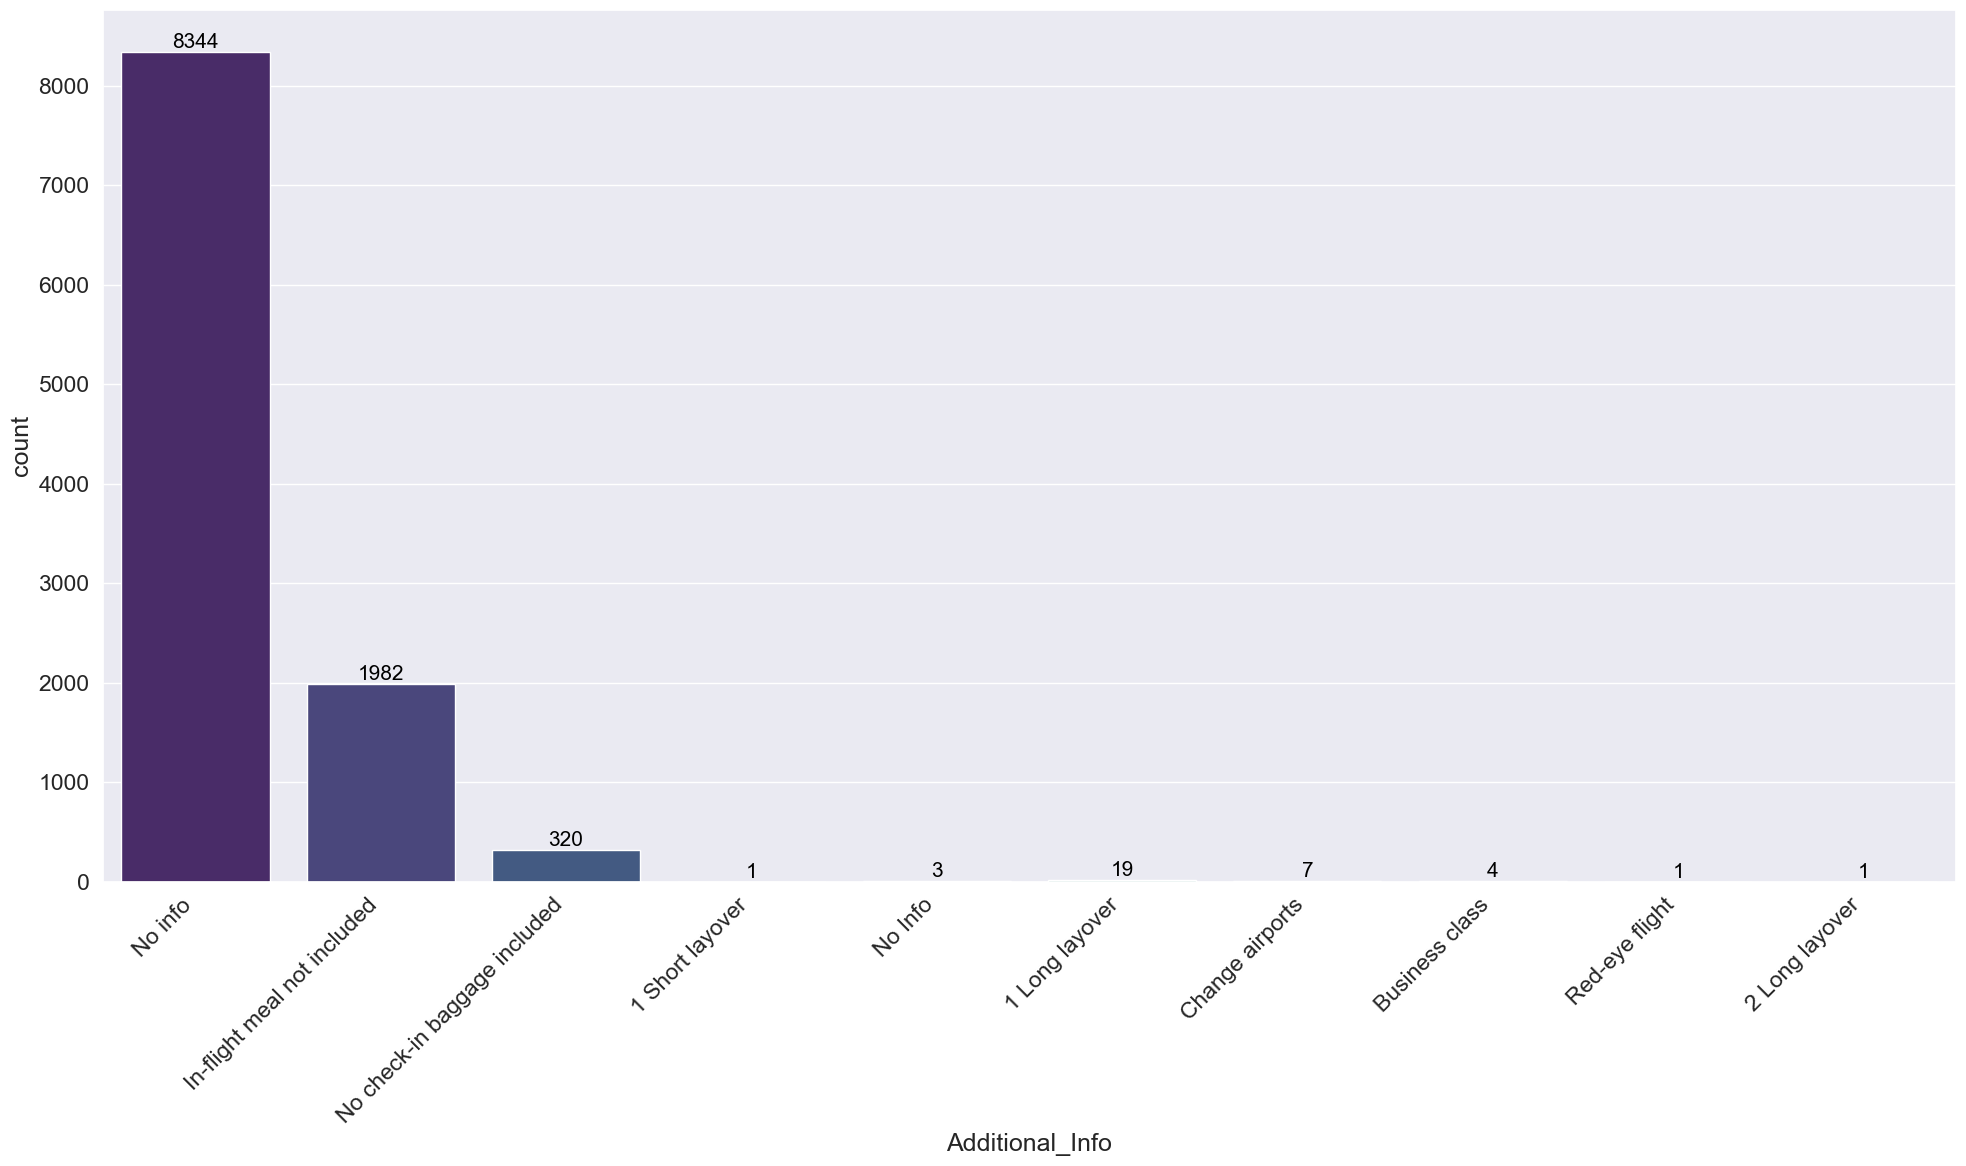

In [48]:
sns.set(font_scale = 1.5)
fig,axes = plt.subplots(figsize=(20,12))
sns.countplot(data=train_data,x="Additional_Info",palette="viridis")
for container in axes.containers:
    axes.bar_label(container,color='black',size=15)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()

- It is evident from above figure that more than 80% values in the Additional_info column have no info at all. Therefore, this column can be dropped too

#### Dropping Route & Additional_info columns

In [49]:
train_data.drop(["Route","Additional_Info"],axis=1,inplace=True)

In [50]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,non-stop,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,13302,1,0,3,16,50,21,35,4,45


In [51]:
# Moving ahead to explore Total_stops column
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

- We need to transform this column so it has only the no of stops from this column as an integer value

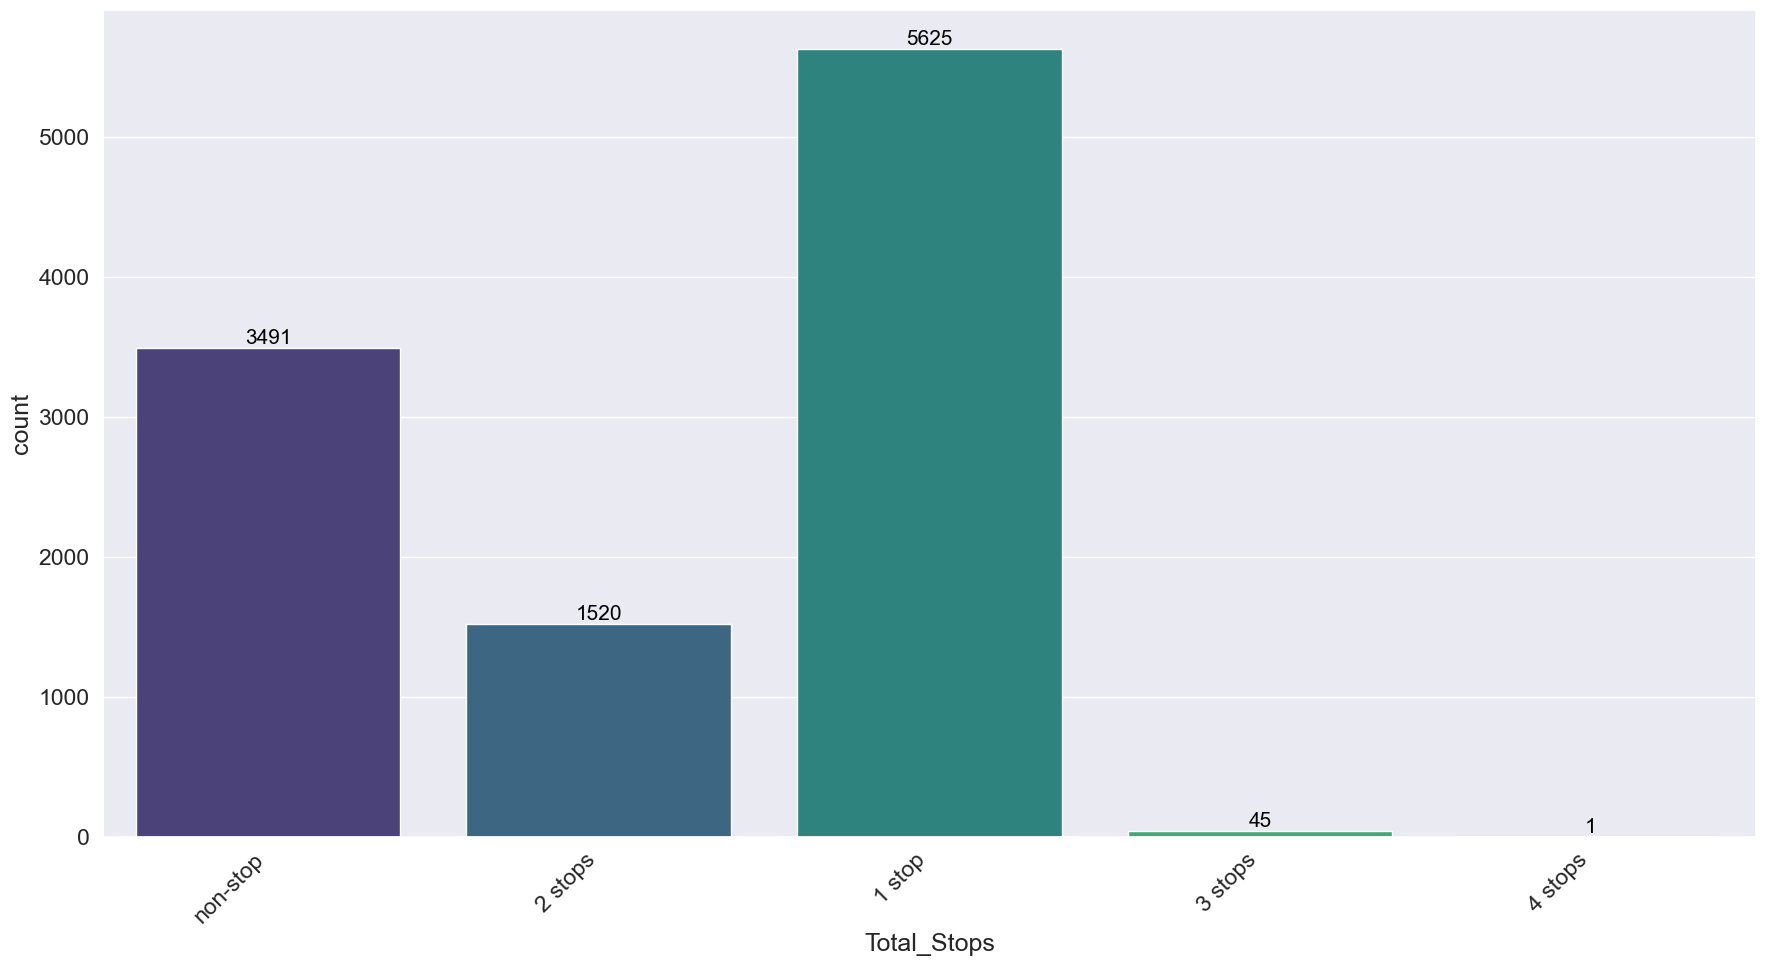

In [52]:
sns.set(font_scale = 1.5)
fig,axes = plt.subplots(figsize=(18,10))
sns.countplot(data=train_data,x="Total_Stops",palette="viridis")
for container in axes.containers:
    axes.bar_label(container,color='black',size=15)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()

- It seems that price of flight increases with number of stops, so it is an ordinal categorical variable.

#### Using LabelEncoder for transforming Total_Stops as it is an ordinal categorical variable

In [53]:
train_data["Total_Stops"].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)

In [54]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,0,3,16,50,21,35,4,45


#### Concatenating all engineered columns to dataset

In [55]:
data_train = pd.concat([train_data,Airline,Source,Destination],axis=1) # axis = 1 specifies concatenation along columns

#### Dropping the original Airline, Source & Destination columns as they have already been transformed

In [56]:
data_train.drop(["Airline","Source","Destination"],axis=1,inplace=True)

In [57]:
data_train.shape

(10682, 30)

In [58]:
data_train.head()

,Total_Stops,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,1,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,0,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,1,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,1,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,0,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Loading Test dataset

In [59]:
test_data = pd.read_excel("Test_set.xlsx")

In [60]:
test_data.shape

(2671, 10)

In [61]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


- As expected, the test data has all the columns same as train data except the Target feature which is Price.

#### Applying the same data cleaning & feature engineering steps for test data as we did for train data

In [62]:
## Data Cleaning

print("Test data Info")
print("-"*60)
print(test_data.info())

print('\n')

# Handling Null Values
print(" Handling Null values \n")
print("-"*60)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# Treating Destination column
print("Treating Destination Column \n")
test_data["Destination"] = test_data["Destination"].apply(lambda x:'Delhi' if x=='New Delhi' else x)


## Feature Engineering

# Date_of_Journey
print("Transforming Date of Journey \n")
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_Weekday"] = pd.to_datetime(test_data["Date_of_Journey"],format='%d/%m/%Y').dt.weekday
test_data["Journey_On_Weekend"] = test_data["Journey_Weekday"].apply(lambda x:1 if x in (5,6) else 0)
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey","Journey_Weekday"], axis = 1, inplace = True)

# Dep_Time
print("Transforming Dep_Time \n")
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
print("Transforming Arrival_Time \n")
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
print("Transforming Duration \n")
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Checks if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extracts only hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data
print("Transforming Airline Column \n")
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print("Transforming Source Column \n")
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print("Transforming Destination Column \n")
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
print("Concatenating all fields \n")
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

print("Dropping redundant columns \n")
data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print('\n')

print("Shape of test data : ", data_test.shape)

Test data Info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


 Handling Null values 

------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time    

In [63]:
data_test.head()

,Total_Stops,Journey_day,Journey_On_Weekend,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata
0,1,6,0,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,12,1,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,21,0,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,21,0,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,0,24,0,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 4. Feature Selection

We will select the most relevant features in training data for building the prediction model so we make sure that redundant or noisy features are removed and the prediction is as accurate as possibe.

For our dataset, we'll using the following feature selection techniques:

1. <span style="color: maroon;">**Comparing Pearson correlation coefficients using heatmap**</span>
2. <span style="color: maroon;">**Comparing Feature_importance_ using ExtraTreesRegressor**</span>
3. <span style="color: maroon;">**Using SelectFromModel with Lasso Regression**</span>
4. <span style="color: maroon;">**Checking Multicollinearity using Variance Inflation Factor**</span>


### 4.1. Comparing Pearson correlation coefficient using heatmap

In [64]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,1,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,0,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,1,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,1,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,0,3,16,50,21,35,4,45


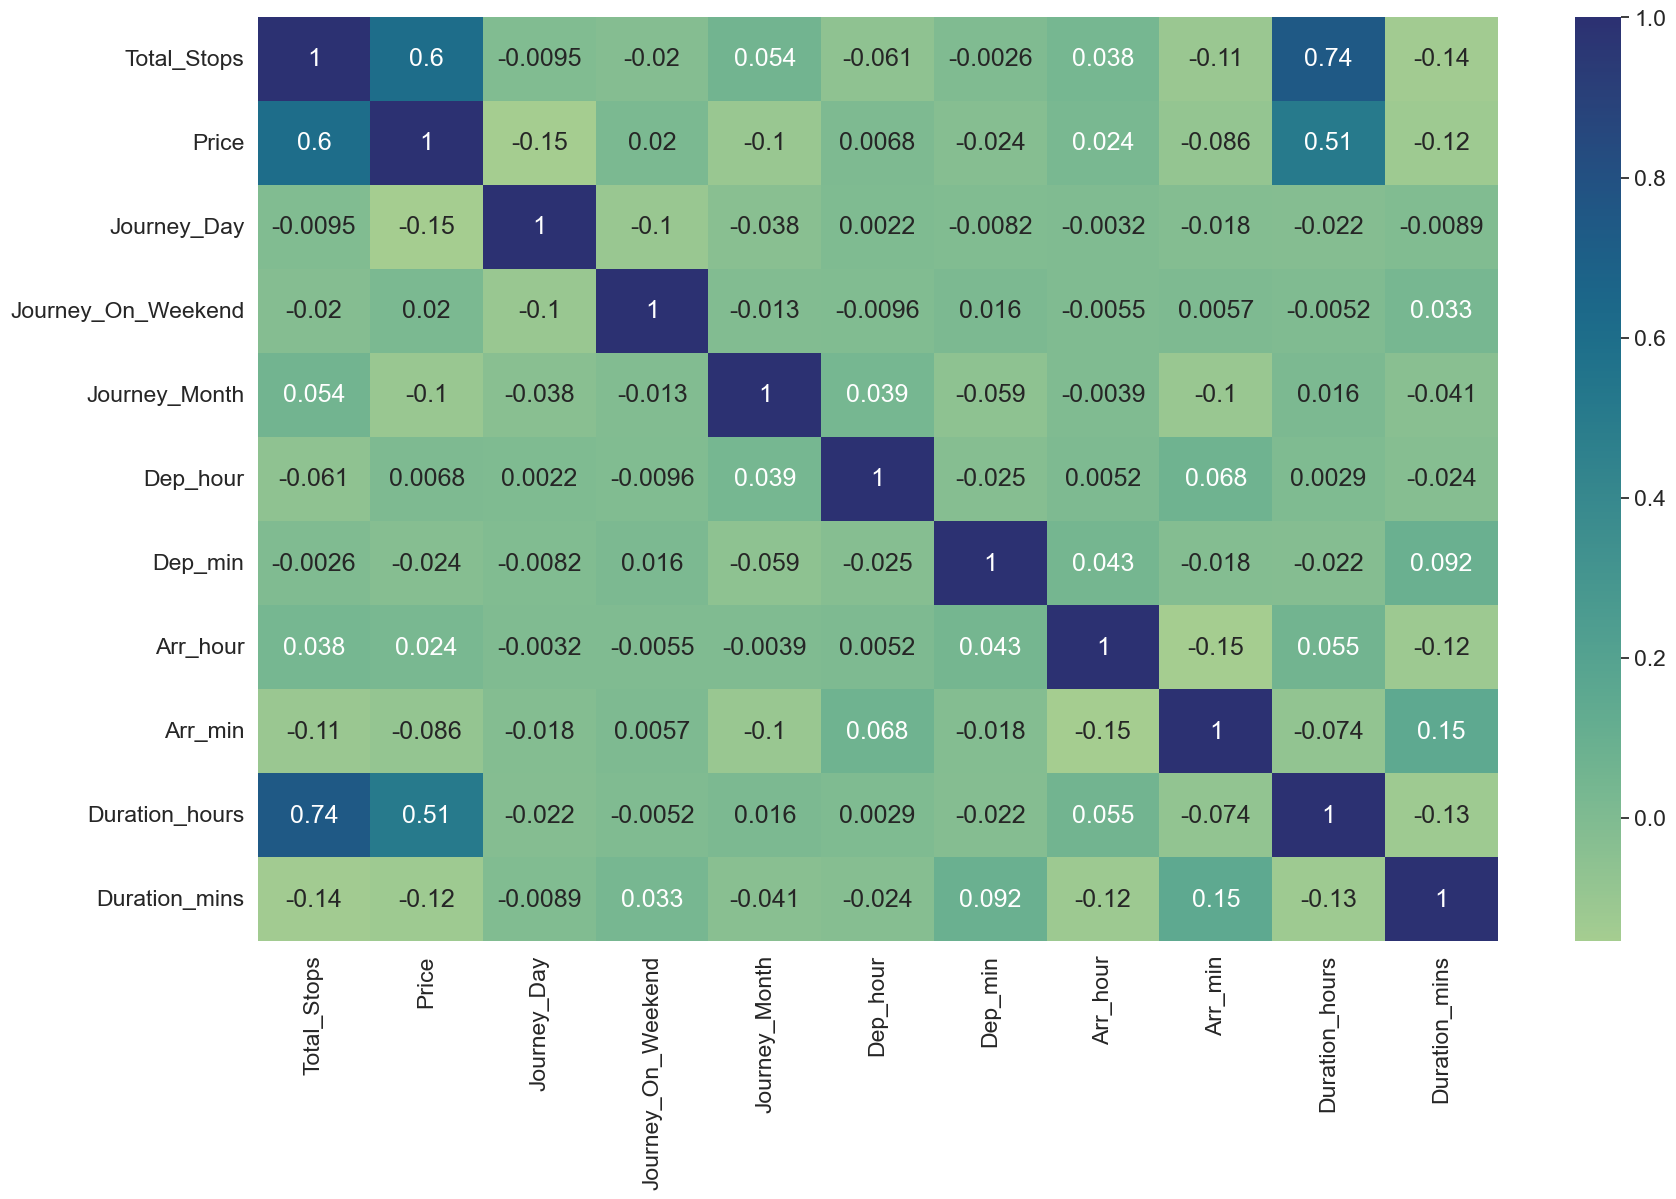

In [65]:
plt.figure(figsize=(20,12))
sns.heatmap(data=train_data.corr(numeric_only=True),annot=True,cmap="crest")

plt.show()


- It seems that the features Total_stops & Duration_hours are the most correlated with Price. Other features don't seem that important

### 4.2. Comparing Feature Importance using ExtraTreesRegressor

ExtraTreesRegressor is generally used to select the best features that can be used to make a predictive model

In [66]:
# Lets store the predictor variables & target variable in separate Dataframes first
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_Day', 'Journey_On_Weekend',
       'Journey_Month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min',
       'Duration_hours', 'Duration_mins', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [67]:
# X Dataframe will contain all the predictor variables in training data
X = data_train.loc[:,['Total_Stops', 'Journey_Day', 'Journey_On_Weekend',
       'Journey_Month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min',
       'Duration_hours', 'Duration_mins', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata']]
X.head()

,Total_Stops,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,1,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,0,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,9,1,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,12,1,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,1,0,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [68]:
# y Dataframe will only contain the target variable(price) in training data
y = data_train.iloc[:,1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [69]:
# Import libraries
# !pip install scikit-learn
from sklearn.ensemble import ExtraTreesRegressor

# Fit the model
select_features = ExtraTreesRegressor()
select_features.fit(X,y)

# Get feature importance
select_features.feature_importances_

array([2.29581813e-01, 1.27430241e-01, 1.35343206e-02, 5.71593318e-02,
       2.45599240e-02, 2.15373547e-02, 2.90317334e-02, 1.93506202e-02,
       1.26922345e-01, 1.78938701e-02, 9.37570742e-03, 1.95519599e-03,
       1.86193339e-02, 1.42485495e-01, 6.73363164e-02, 1.80182952e-02,
       8.63252178e-04, 4.94662943e-03, 1.05905387e-04, 4.54359484e-03,
       6.82806000e-05, 8.45591205e-04, 9.94824178e-03, 4.56151113e-03,
       9.63449597e-03, 1.07456900e-02, 1.86715622e-02, 9.50172416e-03,
       7.71622383e-04])

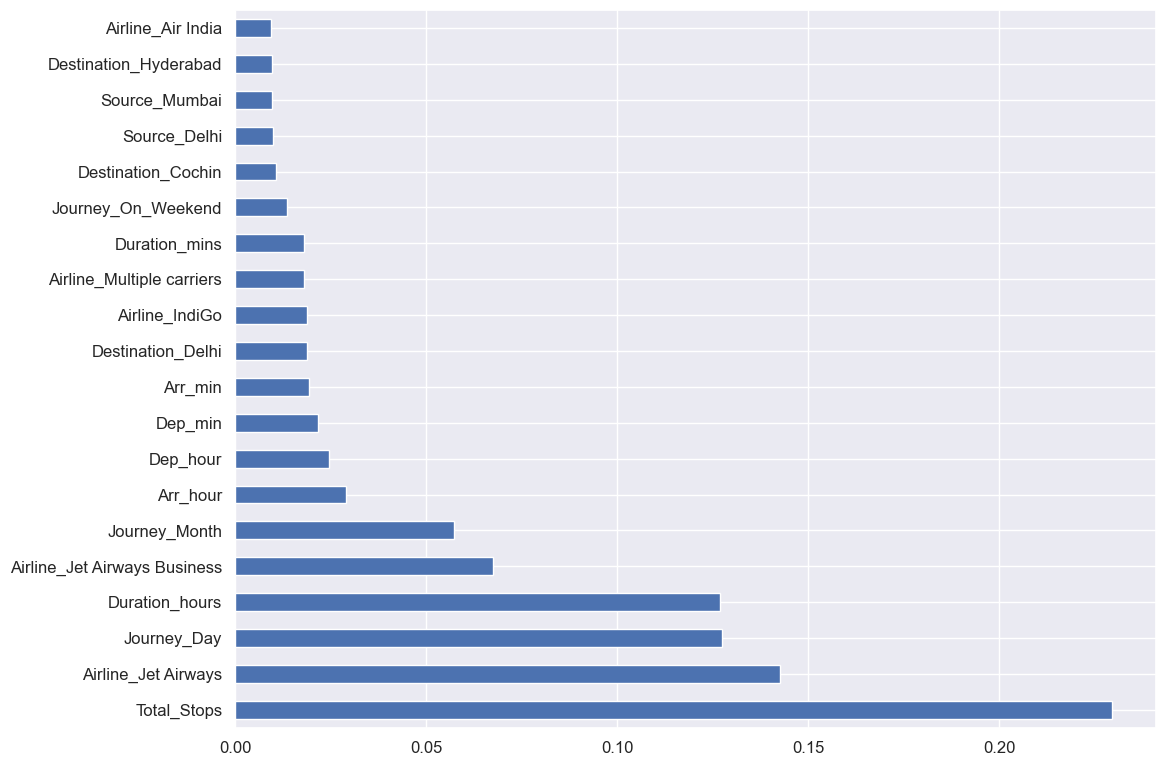

In [70]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(12,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
feature_imp = pd.Series(select_features.feature_importances_,index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')
plt.tight_layout()
plt.show()

- It seems that Total_Stops, Duration_hours, Journey_Day & Journey_Month features are most relevant for predicting price.
- Airline_Jet_Airways & Airline_Jet Always Business features also have a high correlation with price and its beacuse of 2 reasons:
    1) Jet Airways is an outlier Airline when it comes to price of flight as we saw in categorical plots during EDA.
    2) Business class is always more expensive than economy class.

### 4.3. Using SelectFromModel with Lasso Regression

In [71]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

estimator = LassoCV()
selection = SelectFromModel(estimator)
selector = selection.fit(X,y)

status = selector.get_support()
print("Selection status:",status,end='\n\n')

features = np.array(X.columns)
print("All features :",features,end='\n\n')

feature_sel_status = pd.Series(status,index=features)
print(feature_sel_status.head(),end='\n\n')

print("Selected features:",features[status],end='\n\n')

Selection status: [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False  True False  True False False False False
  True False  True  True False]

All features : ['Total_Stops' 'Journey_Day' 'Journey_On_Weekend' 'Journey_Month'
 'Dep_hour' 'Dep_min' 'Arr_hour' 'Arr_min' 'Duration_hours'
 'Duration_mins' 'Airline_Air India' 'Airline_GoAir' 'Airline_IndiGo'
 'Airline_Jet Airways' 'Airline_Jet Airways Business'
 'Airline_Multiple carriers' 'Airline_Multiple carriers Premium economy'
 'Airline_SpiceJet' 'Airline_Trujet' 'Airline_Vistara'
 'Airline_Vistara Premium economy' 'Source_Chennai' 'Source_Delhi'
 'Source_Kolkata' 'Source_Mumbai' 'Destination_Cochin' 'Destination_Delhi'
 'Destination_Hyderabad' 'Destination_Kolkata']

Total_Stops           True
Journey_Day           True
Journey_On_Weekend    True
Journey_Month         True
Dep_hour              True
dtype: bool

Selected features: ['Total_Stops' 'Journey_Day' 'Journey_On_Weekend' 'J

- Using Lasso Regression, The top 5 features correlated with Price seem to be Total_Stops, Journey_Day, Journey_On_Weekend, Journey_Month & Dep_hour

### 4.4. Checking MultiCollinearity using Variance Inflation Factor

In [72]:
X.columns

Index(['Total_Stops', 'Journey_Day', 'Journey_On_Weekend', 'Journey_Month',
       'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [73]:
X.shape

(10682, 29)

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Creating a user defined function to calculate Variable Inflation Factor (VIF)
def calc_vif(z):
    vif = pd.DataFrame()
    vif["Variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values,i) for i in range(z.shape[1])]
    return(vif)

# Computing VIF on X
calc_vif(X)

C:\Users\sambi\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variables,VIF
0,Total_Stops,3.099114
1,Journey_Day,1.035044
2,Journey_On_Weekend,1.020496
3,Journey_Month,1.111993
4,Dep_hour,1.063266
5,Dep_min,1.108434
6,Arr_hour,1.083314
7,Arr_min,1.136907
8,Duration_hours,2.594784
9,Duration_mins,1.142297


- As a rule of thumb, VIF value > 10 is generally a sign of multicollinearity. Here, we are getting high VIF values for Source_Kolkata & Destination_Delhi. And if we look at the feature importance on these variables, we find that Source_Kolkata has lesser feature importance than Destination_Delhi. So we go ahead and drop Source_Kolkata from our features, by declaring our X once again.

#### Drop column Source_Kolkata

In [75]:
# Excluding price & Source_Kolkata columns from X
X = data_train.loc[:,['Total_Stops', 'Journey_Day', 'Journey_On_Weekend',
       'Journey_Month', 'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min',
       'Duration_hours', 'Duration_mins', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata']]

X.head()

,Total_Stops,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,1,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,0,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,9,1,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,1,12,1,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 5. Predictive Modelling

### 5.1 Splitting our data into training & testing datasets

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=24)

We will be testing the following regression models to predict flight price:

1. <span style="color: blue;">**Linear Regression**</span>
2. <span style="color: blue;">**Random Forest Regressor**</span>
3. <span style="color: blue;">**XGBoost Regressor**</span>

In [78]:
# Importing necessary packages
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [79]:
X_train.shape

(8545, 28)

In [80]:
X_train.head()

,Total_Stops,Journey_Day,Journey_On_Weekend,Journey_Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
6435,0,24,0,5,5,45,7,15,1,30,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
8783,0,15,1,6,9,45,12,35,2,50,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
8932,1,9,1,6,14,0,21,0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
5362,0,6,0,5,19,35,21,5,1,30,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
8329,0,9,1,6,15,30,18,5,2,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
y_train.head()

6435     2017
8783     4878
8932    13587
5362     2228
8329     5224
Name: Price, dtype: int64

In [82]:
y_train.shape

(8545,)

### 5.2. Linear Regression

In [83]:
# Fitting Linear Regression Model to train data
reg_ln = LinearRegression()
reg_ln.fit(X_train,y_train)

LinearRegression()

In [84]:
y_pred = reg_ln.predict(X_test)

In [85]:
# Getting R2 value for training data fit
reg_ln.score(X_train,y_train)

0.6164822649532539

In [86]:
# Getting R2 value for testing data fit
reg_ln.score(X_test,y_test)

0.5919853622342965

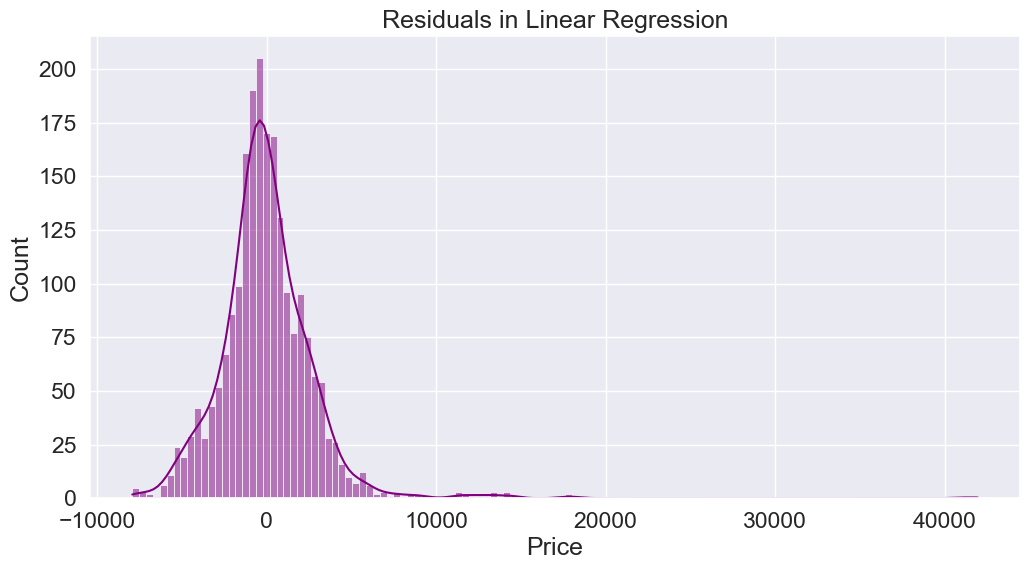

In [104]:
# Plotting the residuals
plt.figure(figsize=(12,6))
plt.title("Residuals in Linear Regression")
sns.histplot(y_test - y_pred,color="purple",kde=True)
plt.show()

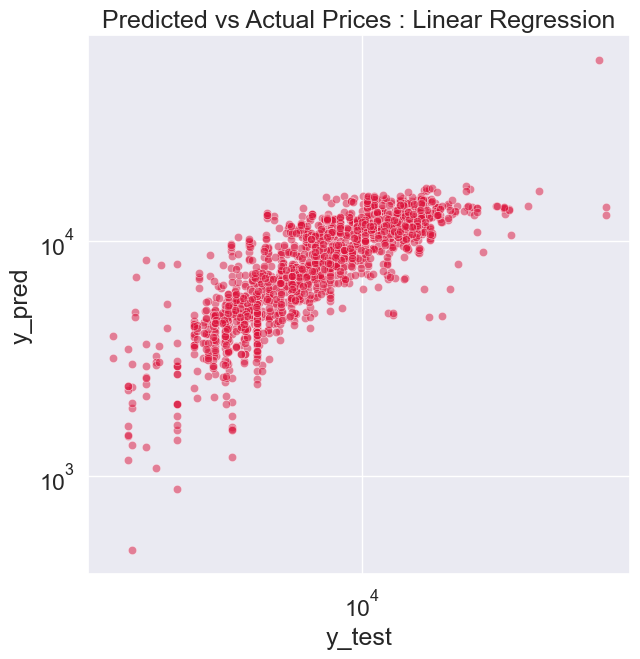

In [88]:
# Plotting linear regression
plt.figure(figsize=(7,7))
sns.scatterplot(y=y_pred,x=y_test,alpha =0.5,color='crimson')
plt.yscale('log')
plt.xscale('log')
plt.title("Predicted vs Actual Prices : Linear Regression")
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

### 5.3. Random Forest Regressor

In [89]:
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train,y_train)

RandomForestRegressor()

In [90]:
y_pred_rf = reg_rf.predict(X_test)

In [91]:
# Getting R2 value for training data fit
reg_rf.score(X_train,y_train)

0.9556449554494597

In [92]:
# Getting R2 value for testing data fit
reg_rf.score(X_test,y_test)

0.8015959733919383

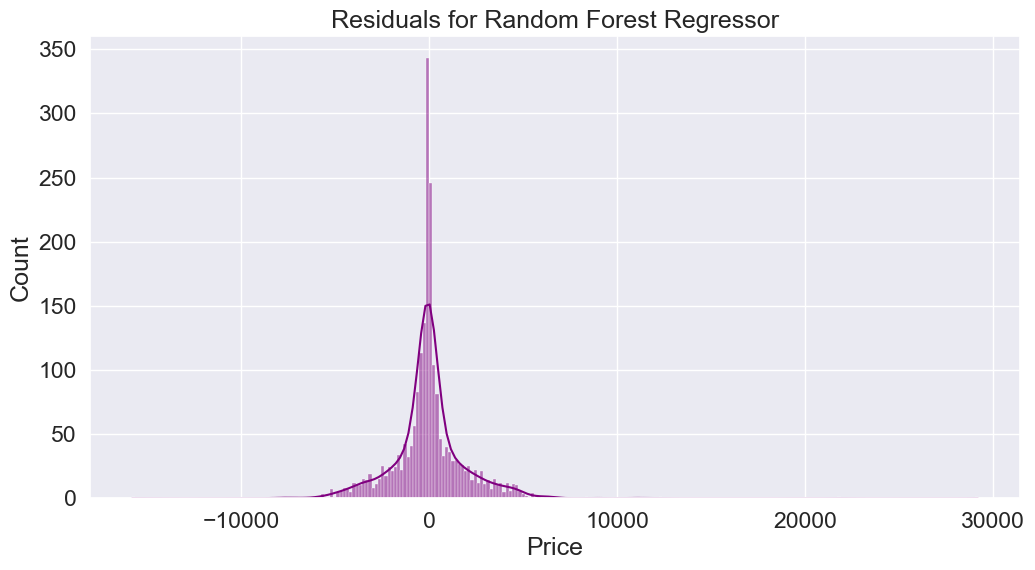

In [108]:
# Plotting the residuals
plt.figure(figsize=(12,6))
plt.title("Residuals for Random Forest Regressor")
sns.histplot(y_test - y_pred_rf,color='purple',kde=True)
plt.show()

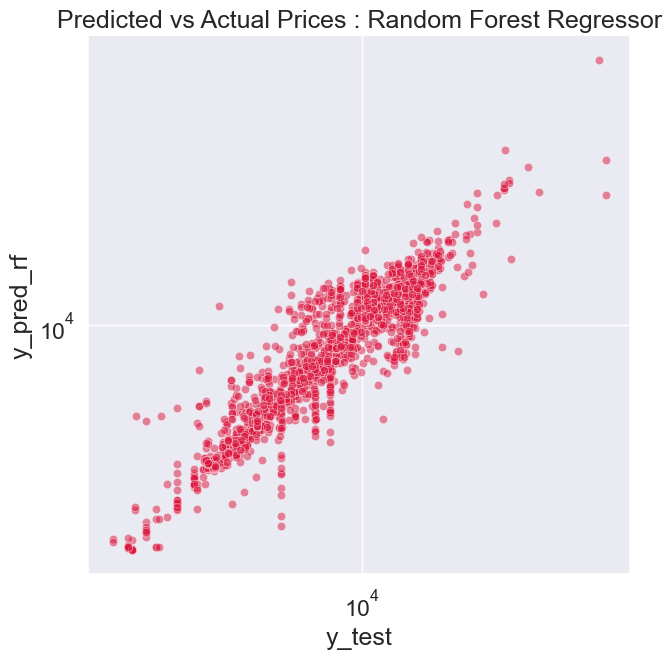

In [103]:
# Plotting predictions for test data against actual prices
plt.figure(figsize=(7,7))
sns.scatterplot(y=y_pred_rf,x=y_test,alpha =0.5,color='crimson')
plt.yscale('log')
plt.xscale('log')
plt.title("Predicted vs Actual Prices : Random Forest Regressor")
plt.xlabel('y_test')
plt.ylabel('y_pred_rf')
plt.show()

- From the R2 scores of respective models, it is evident Random forest(R2 score = 0.80) a better predictive model than Linear Regression (R2 score = 0.59) when we consider test data. 
- We'll be testing the XGBoost Regressor model shortly to check if it performs better than the above 2 models.

### 5.4. XGBoost Regressor

In [95]:
reg_xgb = XGBRegressor()
reg_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [96]:
y_pred_xgb = reg_xgb.predict(X_test)

In [97]:
reg_xgb.score(X_train,y_train)

0.933908874037649

In [98]:
reg_xgb.score(X_test,y_test)

0.8121253553201837

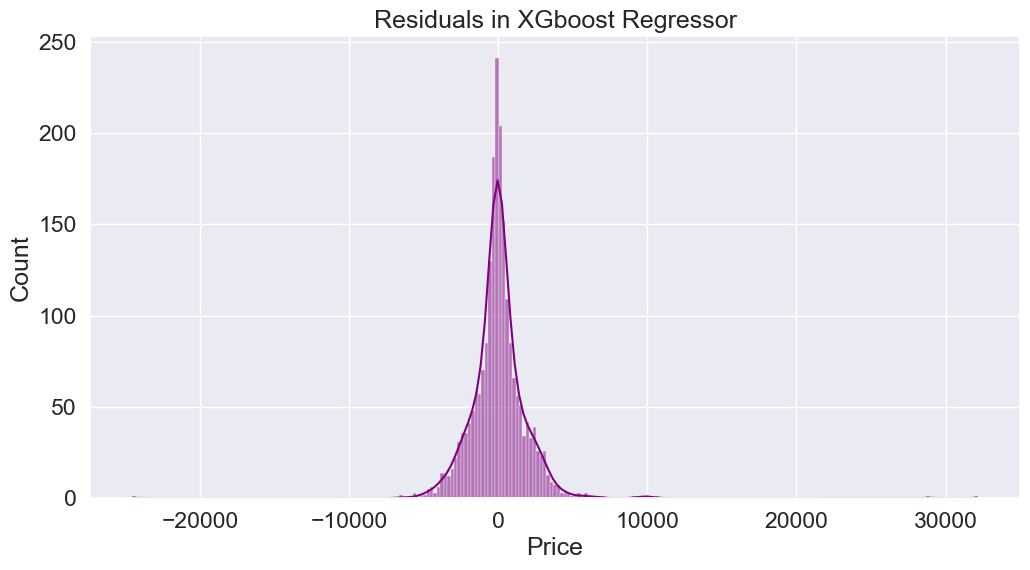

In [106]:
# Plotting the residuals
plt.figure(figsize=(12,6))
plt.title("Residuals in XGboost Regressor")
sns.histplot(y_test - y_pred_xgb,color='purple',kde=True)
plt.show()

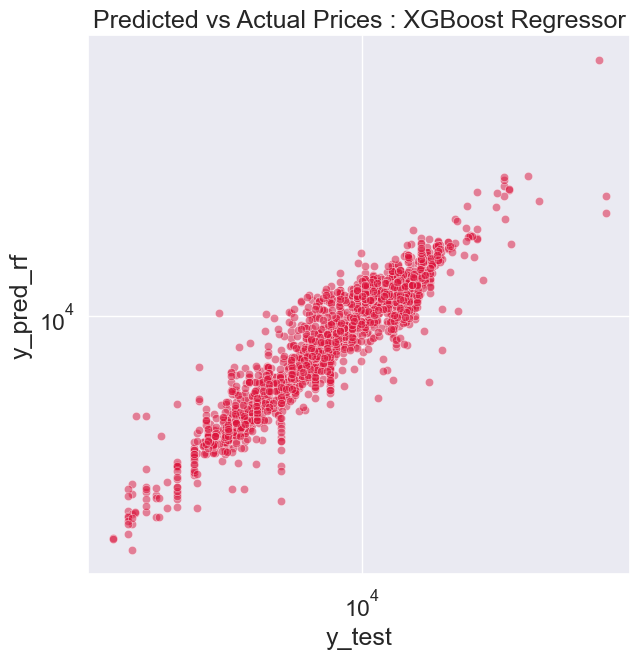

In [102]:
# Plotting predictions for test data against actual prices
plt.figure(figsize=(7,7))
sns.scatterplot(y=y_pred_xgb,x=y_test,alpha =0.5,color='crimson')
plt.yscale('log')
plt.xscale('log')
plt.title("Predicted vs Actual Prices : XGBoost Regressor")
plt.xlabel('y_test')
plt.ylabel('y_pred_rf')
plt.show()

In [111]:
# Using error metrics to evaluate the 3 models
from sklearn import metrics

print("Evaluating Performance of Linear Regression Model ")
print("-" * 75)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

print("Evaluating Performance of Random Forest Regressor Model ")
print("-" * 75)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)),'\n')

print("Evaluating Performance of XGBoost Regressor Model ")
print("-" * 75)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)),'\n')

Evaluating Performance of Linear Regression Model 
---------------------------------------------------------------------------
MAE: 1904.8870502929472
MSE: 8642044.857039165
RMSE: 2939.7355080073385 

Evaluating Performance of Random Forest Regressor Model 
---------------------------------------------------------------------------
MAE: 1212.3478554860362
MSE: 4202340.649230959
RMSE: 2049.961133590332 

Evaluating Performance of XGBoost Regressor Model 
---------------------------------------------------------------------------
MAE: 1203.623774784215
MSE: 3979320.731516519
RMSE: 1994.8234837991354 



- It is clear that XGBoost Regressor is the best performing model

## 6. Hyperparameter Tuning